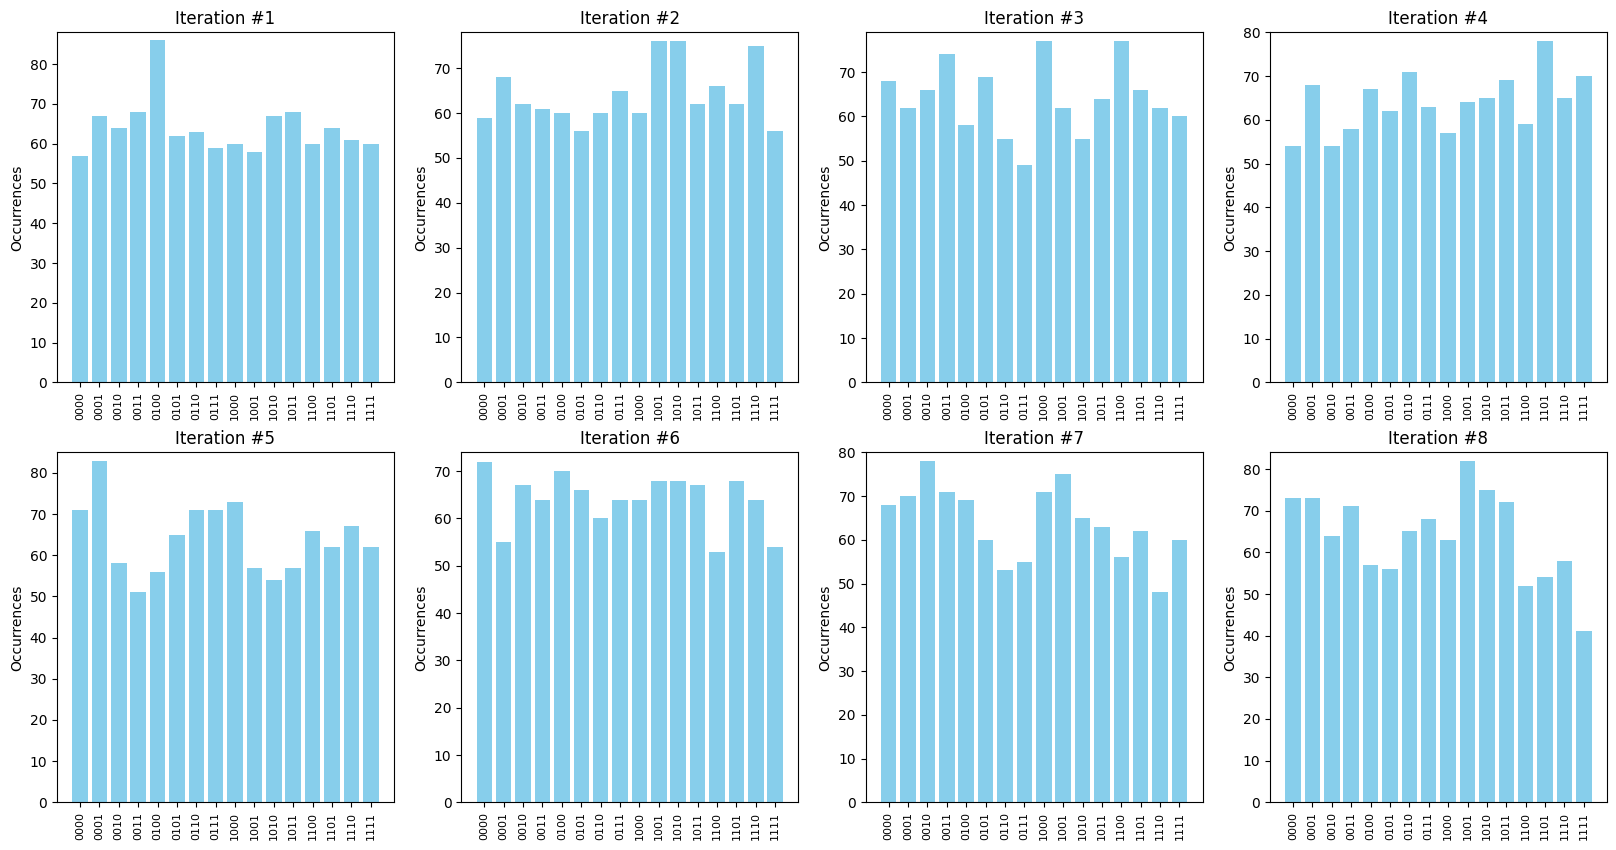

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import math

NUM_QUBITS = 4
NUM_ITERATIONS = 8
CLAUSE_LIST = [[0,1]]

def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

def get_oracle(qc, clause_list, clause_qubits, output_qubit):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mcx(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mcx(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

def run_simulation():
    all_results = []
    for n in range(NUM_ITERATIONS):
        var_qubits = QuantumRegister(NUM_QUBITS, name='v')
        clause_qubits = QuantumRegister(len(CLAUSE_LIST), name='c')
        output_qubit = QuantumRegister(1, name='out')
        cbits = ClassicalRegister(NUM_QUBITS, name='cbits')
        qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

        # Initialize 'out0' in state |->
        qc.initialize([1, -1]/np.sqrt(2), output_qubit)

        # Initialize qubits in state |s>
        qc.h(var_qubits)
        qc.barrier()  # for visual separation

        def add_step():
            get_oracle(qc, CLAUSE_LIST, clause_qubits, output_qubit)
            qc.barrier()  # for visual separation
            qc.append(diffuser(4), [0,1,2,3])

        for _ in range(n):
            add_step()

        # Measure the variable qubits
        qc.measure(var_qubits, cbits)

        simulator = AerSimulator()
        transpiled_qc = transpile(qc, simulator)
        result = simulator.run(transpiled_qc).result()
        all_results.append(result.get_counts())

    return all_results

def get_all_bits_ordered_list():
    return [format(i, f"0{NUM_QUBITS}b") for i in range(2 ** NUM_QUBITS)]

def plot_stuff(results):
    # Get all possible basis states from number of qubits
    all_keys = get_all_bits_ordered_list()

    # Ensure all dictionaries have all the keys for the data
    completed_dicts = []
    for curr_result in results:
        completed_dicts.append({key: curr_result.get(key, 0) for key in all_keys})

    # Create subplots (2 rows, 4 columns)
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    axs = axs.flatten()

    # Plot each dictionary as a bar graph
    for i, data in enumerate(completed_dicts):
        ax = axs[i]
        values = [data[k] for k in all_keys]
        ax.bar(all_keys, values, color="skyblue")
        ax.set_title(f"Iteration #{i+1}")
        ax.set_ylim(0, max(values) + 2)
        ax.set_ylabel("Occurrences")

        # Rotate x-axis labels vertically and reduce font size
        ax.set_xticks(range(len(all_keys)))
        ax.set_xticklabels(all_keys, rotation="vertical", fontsize=8)
 


results = run_simulation()
plot_stuff(results)
